In [32]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

from math import log, sqrt, pi, exp
from scipy.stats import norm
#from pandas import DataFrame
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

from sklearn.metrics import mean_absolute_percentage_error

import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yfin
yfin.pdr_override()

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
plt.rcParams["figure.figsize"] = (10,6)
import warnings

from pykalman import KalmanFilter
import numpy as np


from darts.models import KalmanForecaster
from darts.utils.timeseries_generation import datetime_attribute_timeseries, constant_timeseries
from darts.timeseries import TimeSeries as ts


# Assignment

1. Familiarize yourself with Nau notes - Statistical Forecasting: notes on regression and time series analysis
2. Readings on Kalman Filer and Sine Wave price estimators
3. Implement a Kalman Filter in Python, R or MatLab
4. Use your Kalman Filter to predict the closing price of one of the stocks in your portfolio for 4 future days
5. Document and post your predictions and the actual closing prices of those stocks
6. Comment on the posts of your colleagues
7. Post your comments on market events effecting your portfolio

# Setup

## Varaibles

In [2]:
start = datetime(2023, 1, 1)
today = datetime.today()

sp_list = ['IVV']

# Load Data

In [3]:
df = pdr.get_data_yahoo(sp_list, start=start, end=today)
df.tail(20)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-06,423.87,433.02,422.46,431.37,431.37,4153500
2023-10-09,429.45,434.79,428.92,434.21,434.21,2675500
2023-10-10,434.89,439.15,434.47,436.48,436.48,4430000
2023-10-11,437.63,438.50,435.10,438.33,438.33,3875600
2023-10-12,438.91,439.28,433.17,435.70,435.70,4232300
2023-10-13,437.18,438.38,431.79,433.41,433.41,4041200
2023-10-16,435.74,439.08,435.53,437.92,437.92,4656900
2023-10-17,434.73,440.05,434.40,438.05,438.05,4864000
2023-10-18,436.14,437.09,430.98,432.31,432.31,7890000


# Kalman Filter

In [4]:
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                  observation_matrices = [1],   # The value for Ht.
                  initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                  initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                  observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                  transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0

# Get the Kalman smoothing
state_means, covariances = kf.filter(df['Adj Close'].values)

# Call it KF_mean
df['KF_mean'] = np.array(state_means)
df.tail(20)

,Open,High,Low,Close,Adj Close,Volume,KF_mean
Date,,,,,,,
2023-10-06,423.87,433.02,422.46,431.37,431.37,4153500,433.96
2023-10-09,429.45,434.79,428.92,434.21,434.21,2675500,433.98
2023-10-10,434.89,439.15,434.47,436.48,436.48,4430000,434.22
2023-10-11,437.63,438.50,435.10,438.33,438.33,3875600,434.61
2023-10-12,438.91,439.28,433.17,435.70,435.70,4232300,434.72
2023-10-13,437.18,438.38,431.79,433.41,433.41,4041200,434.59
2023-10-16,435.74,439.08,435.53,437.92,437.92,4656900,434.91
2023-10-17,434.73,440.05,434.40,438.05,438.05,4864000,435.21
2023-10-18,436.14,437.09,430.98,432.31,432.31,7890000,434.93


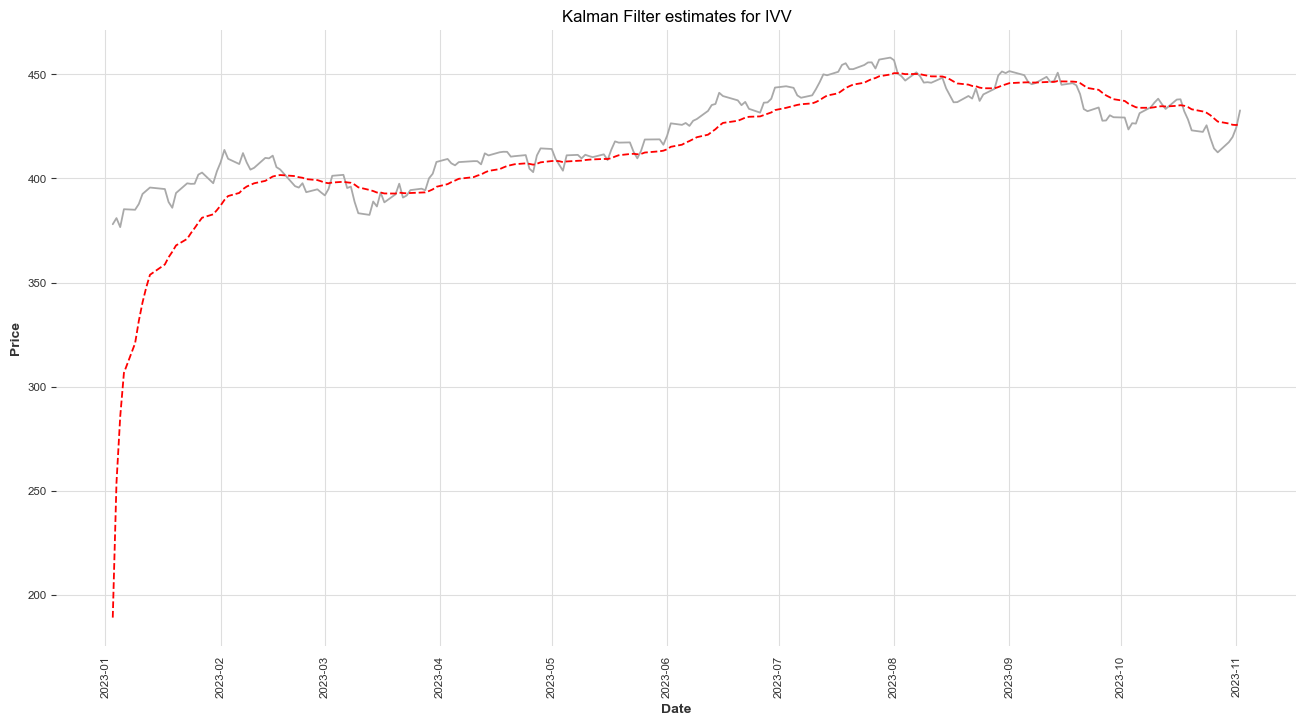

In [5]:
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='x', labelrotation=90) 
xticks = xticks = df.index.tolist()

sns.set_style("white")
g = sns.lineplot(data=df, x=df.index, y="Adj Close", color='darkgray')
g = sns.lineplot(data=df, x=df.index, y="KF_mean", linestyle="dashed", color='red')

ax.set(title='Kalman Filter estimates for IVV', ylabel='Price');

In [6]:
# Predict Next Days Cloase
next_mean, next_covariance = kf.filter_update(state_means[-1], covariances[-1], )
print('next_mean: ' , next_mean[0] ,' ', 'next_covariance: ',  next_covariance[0][0])

next_mean:  426.3450107401805   next_covariance:  0.10512492197250393


In [7]:
# Number of future predictions you want
num_predictions = 5
predicted_prices = []

for _ in [1,2,3,4,5]:
    (next_mean, next_covariance) = kf.filter_update(next_mean, next_covariance)
    print('next_mean: ' , next_mean[0] ,' ', 'next_covariance: ',  next_covariance[0][0])


next_mean:  426.3450107401805   next_covariance:  0.11512492197250393
next_mean:  426.3450107401805   next_covariance:  0.12512492197250394
next_mean:  426.3450107401805   next_covariance:  0.13512492197250395
next_mean:  426.3450107401805   next_covariance:  0.14512492197250396
next_mean:  426.3450107401805   next_covariance:  0.15512492197250397


# Kalman Filter - Individual Estimates

In [8]:
result_df = pd.DataFrame(columns=['Date','Adj Close','KF_mean'])

for i in [-5,-4,-3,-2,-1]:
    print(df[['Adj Close']].iloc[[i]])
    next_mean, next_covariance = kf.filter_update(state_means[i], covariances[i], )
    print('next_mean: ' , next_mean[0] ,' ', 'next_covariance: ',  next_covariance[0][0])
    #df = df.append({'Date' : df.index[-5], 'Adj Close' : df['Adj Close'].iloc[-5], 'KF_mean' : df['KF_mean'].iloc[-5]}, ignore_index = True)
    
    list_row = [df.index[i], df['Adj Close'].iloc[i], df['KF_mean'].iloc[i]]
    result_df.loc[len(result_df)] = list_row

            Adj Close
Date                 
2023-10-27     412.55
next_mean:  427.35413181477935   next_covariance:  0.10512492197250393
            Adj Close
Date                 
2023-10-30     417.45
next_mean:  426.41200320988594   next_covariance:  0.10512492197250393
            Adj Close
Date                 
2023-10-31     419.94
next_mean:  425.79635464177835   next_covariance:  0.10512492197250393
            Adj Close
Date                 
2023-11-01     424.53
next_mean:  425.6758926391704   next_covariance:  0.10512492197250393
            Adj Close
Date                 
2023-11-02     432.71
next_mean:  426.3450107401805   next_covariance:  0.10512492197250393


In [9]:
result_df

,Date,Adj Close,KF_mean
0,2023-10-27,412.55,427.35
1,2023-10-30,417.45,426.41
2,2023-10-31,419.94,425.80
3,2023-11-01,424.53,425.68
4,2023-11-02,432.71,426.35


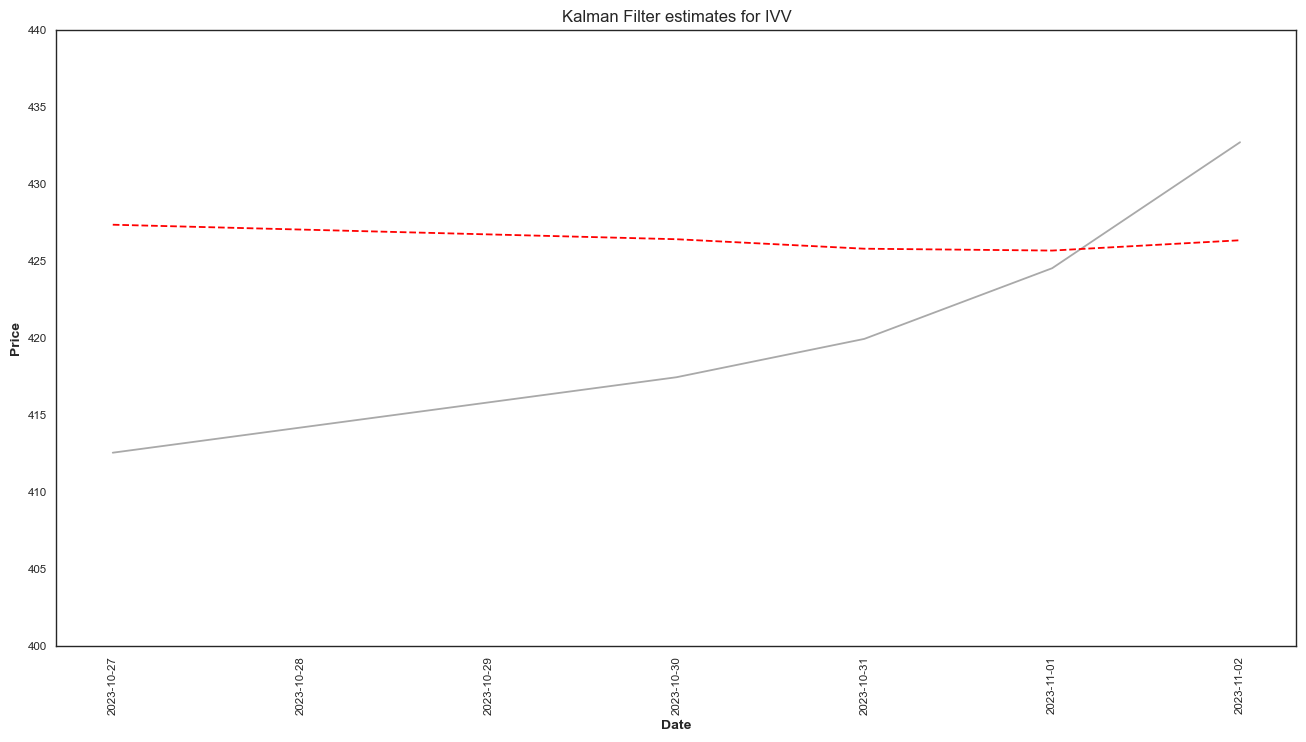

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')
ax.set_ylim(400, 440)
ax.tick_params(axis='x', labelrotation=90) 
xticks = xticks = df.index.tolist()

sns.set_style("white")
g = sns.lineplot(data=result_df, x=result_df['Date'], y="Adj Close", color='darkgray')
g = sns.lineplot(data=result_df, x=result_df['Date'], y="KF_mean", linestyle="dashed", color='red')

ax.set(title='Kalman Filter estimates for IVV', ylabel='Price');

# Update Kalman Filter using DART

In [15]:
# first try, filling in empty dates with mean stock price (required for the timeseries datatype
# when frequency is listed as "daily")


fill_val = df['Adj Close'].mean()

#kf_train = kf_train.set_index(['Date'])
kf_train = df[['Adj Close']].copy()
kf_train = ts.from_dataframe(kf_train, value_cols=['Adj Close'],
                             fillna_value=fill_val,freq='D',fill_missing_dates=True)
#kf_train = ts.from_dataframe(kf_sample, value_cols=['GOOGL'])
future_cov = datetime_attribute_timeseries(kf_train, 'day', add_length=5)

model = KalmanForecaster(dim_x=1)
model.fit(kf_train, future_covariates=future_cov)
pred = model.predict(5, future_covariates=future_cov)
preds = pred.values().reshape(-1)
preds

array([422.70467369, 422.85436386, 423.00057241, 423.1432985 ,
       423.28254131])

In [16]:
result_df['KF_mean_dart'] = preds

In [17]:
result_df

,Date,Adj Close,KF_mean,KF_mean_dart
0,2023-10-27,412.55,427.35,422.70
1,2023-10-30,417.45,426.41,422.85
2,2023-10-31,419.94,425.80,423.00
3,2023-11-01,424.53,425.68,423.14
4,2023-11-02,432.71,426.35,423.28


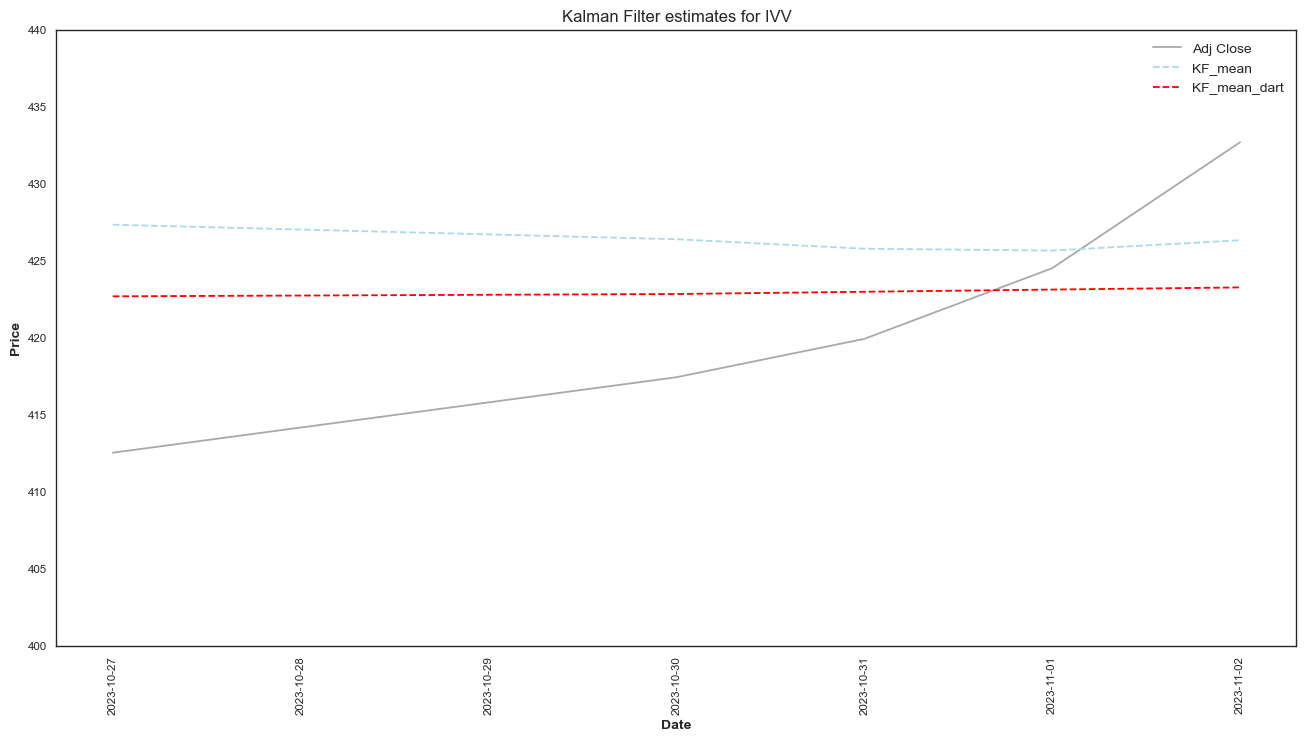

In [30]:
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')
ax.set_ylim(400, 440)
ax.tick_params(axis='x', labelrotation=90) 
xticks = xticks = df.index.tolist()

sns.set_style("white")
g = sns.lineplot(data=result_df, x='Date', y="Adj Close", color='darkgray', label='Adj Close')
g = sns.lineplot(data=result_df, x='Date', y="KF_mean", linestyle="dashed", color='lightblue', label='KF_mean')
g = sns.lineplot(data=result_df, x='Date', y="KF_mean_dart", linestyle="dashed", color='red', label='KF_mean_dart')

ax.set(title='Kalman Filter estimates for IVV', ylabel='Price');

# Conclusion

The predictions from the 2 types fo Kalman Filters have a very close MAPE score. With the pykalman Filter having a slightly lower MAPE than the DAT Kalman Filter

In [34]:
print('KF_mean', mean_absolute_percentage_error(result_df['Adj Close'], result_df['KF_mean']))
print('KF_mean_dart', mean_absolute_percentage_error(result_df['Adj Close'], result_df['KF_mean_dart']))

KF_mean 0.017741474558313878
KF_mean 0.0139804171518714
